In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## ICs w/ novel splicing

In [10]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
print(len(df.index))
temp = df.loc[(df.structural_category!='full-splice_match')&\
              (df.structural_category!='incomplete-splice_match')]
print(len(temp.index))

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

12993951
4280955


In [11]:
cell_line_ids = temp.cell_line_id.unique().tolist()

In [28]:
len(temp.ic_id.unique())

103547

In [37]:
import itertools

big_df = pd.DataFrame()
# each group of 28
combinations = list(itertools.combinations(cell_line_ids, 28))
for i, comb in enumerate(combinations[:5]):
    
    # how many ICs do we detect w/ hg38 for these?
    ic_hg38 = temp.loc[(temp.cell_line_id.isin(comb))&\
                              (temp.hg38==True)].ic_id.unique()
    n_ic_hg38 = len(ic_hg38)
    
    # how many ICs do we detect w/ pers. haps for these?
    ic_pers = temp.loc[(temp.cell_line_id.isin(comb))&\
                          ((temp.hap1+temp.hap2)>0)].ic_id.unique()
    n_ic_pers = len(ic_pers)
    
    
    # addition of things
    missing_ids = list(set(cell_line_ids)-set(comb))    
    # how many ics would we get by adding 2 rna-seq samples 
    # (ie hg38 samples, both missing)
    ics_rna_seq = temp.loc[(temp.cell_line_id.isin(missing_ids))&\
                          (temp.hg38==True)].ic_id.unique()
    n_ics_rna_seq_hg38 = len(list(set(ics_rna_seq)-set(ic_hg38)))
    n_ics_rna_seq_pers = len(list(set(ics_rna_seq)-set(ic_pers)))
    
    # how many ics would we get by adding 1 rna-seq sample
    # w/ personalized haplotype?
    # (ie hap1/hap2 samples, 1 missing sample at a time)
    for j, missing_cell_line_id in enumerate(missing_ids):
        # how many ics would we get by adding 2 rna-seq samples 
        ics_rna_wgs_seq = temp.loc[(temp.cell_line_id==missing_cell_line_id)&\
                              (temp.hg38==True)].ic_id.unique()
        n_ics_rna_wgs_seq_hg38 = len(list(set(ics_rna_wgs_seq)-set(ic_hg38)))
        n_ics_rna_wgs_seq_pers = len(list(set(ics_rna_wgs_seq)-set(ic_pers)))
        
        
        data = [[i, j, n_ic_hg38, n_ic_pers,
                n_ics_rna_seq_hg38, n_ics_rna_seq_pers,
                n_ics_rna_wgs_seq_hg38, n_ics_rna_wgs_seq_pers]]
        cols = ['iter_28_samples', 'iter_missing_samples', 'n_ic_hg38', 'n_ic_pers',
                'n_ics_rna_seq_hg38', 'n_ics_rna_seq_pers',
                'n_ics_rna_wgs_seq_hg38', 'n_ics_rna_wgs_seq_pers']
        temp3 = pd.DataFrame(data=data, columns=cols)
        big_df = pd.concat([temp3, big_df], axis=0)

In [47]:
# big_df.to_csv('250305_28_sample_experiment.tsv', sep='\t') # this one was saved w/ all 434 combinations

In [33]:
len(temp.loc[(temp.cell_line_id.isin(comb))&\
          (temp.hg38==True)].ic_id.unique())

95997

In [41]:
temp = big_df.drop(['iter_missing_samples', 'n_ics_rna_wgs_seq_hg38', 'n_ics_rna_wgs_seq_pers'], axis=1).drop_duplicates()

In [42]:
len(big_df.index)

870

In [43]:
len(temp.index)

435

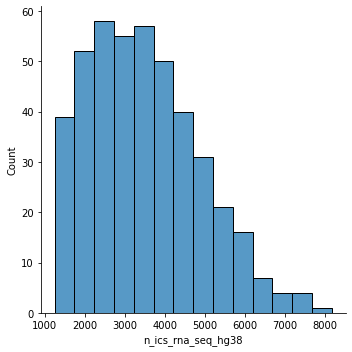

In [46]:
sns.displot(temp, kind='hist', x='n_ics_rna_seq_hg38')

In [ ]:
# debugging